# Importing libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data

%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

# Importing the data

In [2]:
hist_prod_demand=pd.read_csv('C:/Users/Caio Laptop/OneDrive - The University of Kansas/Documents/PhD/11. Courses/19. EECS 731 - Introduction to Data Science/Homework/Section 7 - HW/Datasets/Historical Product Demand.csv')

# Taking a look in my data

In [3]:
print("Shape: %s" % str(hist_prod_demand.shape))
print("------------------------------------------------------------------")
print("Column names: %s" % str(hist_prod_demand.columns))
print("------------------------------------------------------------------")
str(hist_prod_demand.info())
print("------------------------------------------------------------------")
print(hist_prod_demand.describe())
print("------------------------------------------------------------------")
print(hist_prod_demand.dtypes)
print("------------------------------------------------------------------")
hist_prod_demand.head()

Shape: (1048575, 5)
------------------------------------------------------------------
Column names: Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')
------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
Product_Code        1048575 non-null object
Warehouse           1048575 non-null object
Product_Category    1048575 non-null object
Date                1037336 non-null object
Order_Demand        1048575 non-null object
dtypes: object(5)
memory usage: 20.0+ MB
------------------------------------------------------------------
        Product_Code Warehouse Product_Category       Date Order_Demand
count        1048575   1048575          1048575    1037336      1048575
unique          2160         4               33       1729         3828
top     Product_1359    Whse_J     Category_019  2013/9/27        

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


# Data Wrangling

In [4]:
hist_prod_demand2=hist_prod_demand[['Date', 'Order_Demand']]

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
hist_prod_demand2['Date'] = pd.to_datetime(hist_prod_demand2['Date'])
## hist_prod_demand2['Date']=hist_prod_demand2['Date'].astype('datetime64[ns]')

In [7]:
hist_prod_demand2['Order_Demand']=hist_prod_demand2['Order_Demand'].apply(pd.to_numeric, errors='coerce')

In [8]:
demand = hist_prod_demand2['Order_Demand']
demand = demand.fillna(method='ffill')
demand.head()

0    100.0
1    500.0
2    500.0
3    500.0
4    500.0
Name: Order_Demand, dtype: float64

# Plotting

In [9]:
# Below I left some sketches
#===================================================================
# fig = plt.figure(figsize=(18,16))
# ax = fig.add_subplot(111)
# ax.plot(hist_prod_demand2['Date'], demand, color='black')
# plt.show()

# fig = plt.figure(figsize=(18,16))
# ax = fig.add_subplot(111)
# ax.scatter(hist_prod_demand2['Date'], demand, color='darkgreen', marker='o')
# plt.show()
#===================================================================

In [10]:
## Plotting the demand from observations 0 to 10,000

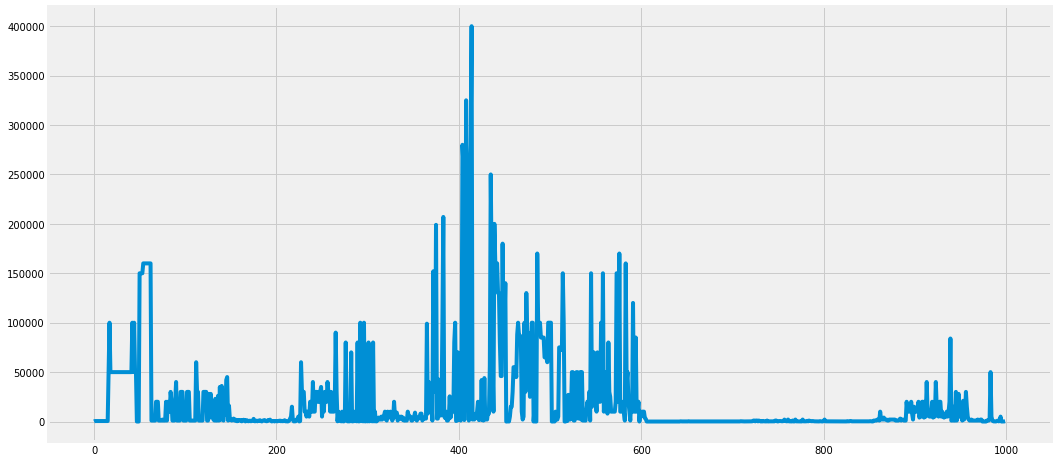

In [11]:
#hist_prod_demand2['Order_Demand'].plot(figsize=(16,8))
demand.iloc[0:1000].plot(figsize=(16,8), linestyle='solid')

## Plotting the demand from observations 10,001 to 15,000

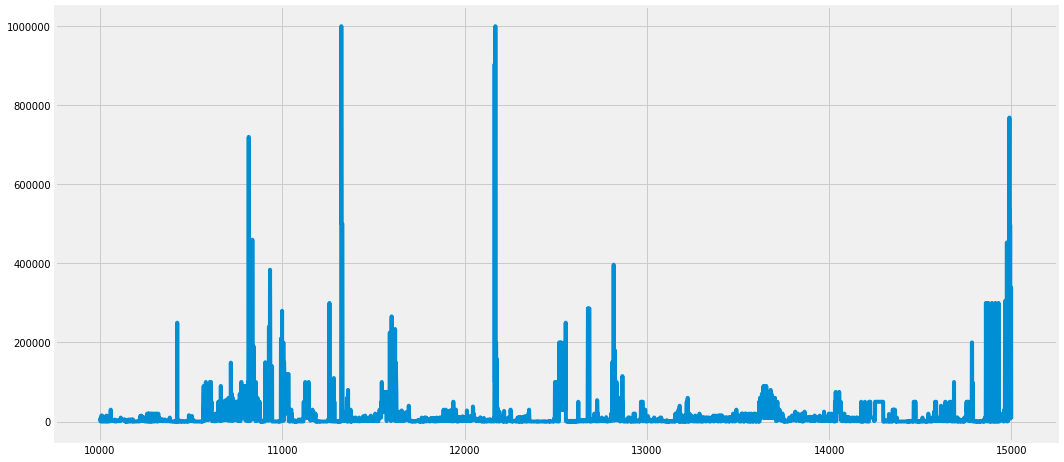

In [12]:
demand.iloc[10001:15000].plot(figsize=(16,8), linestyle='solid')

## Plotting the demand for the entire series

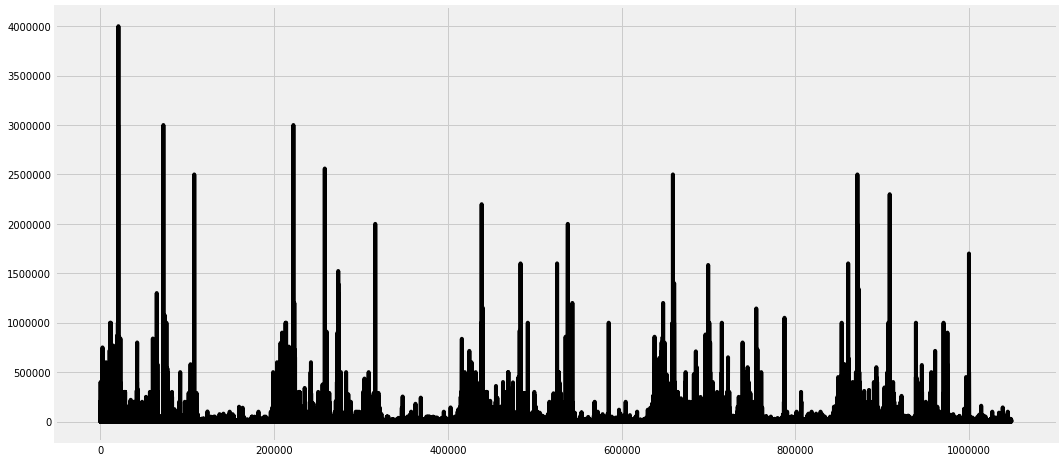

In [13]:
demand.plot(figsize=(16,8), linestyle='solid', color='black')

## For purposes of Statistical Analysis, let's plotting the demand differentiated

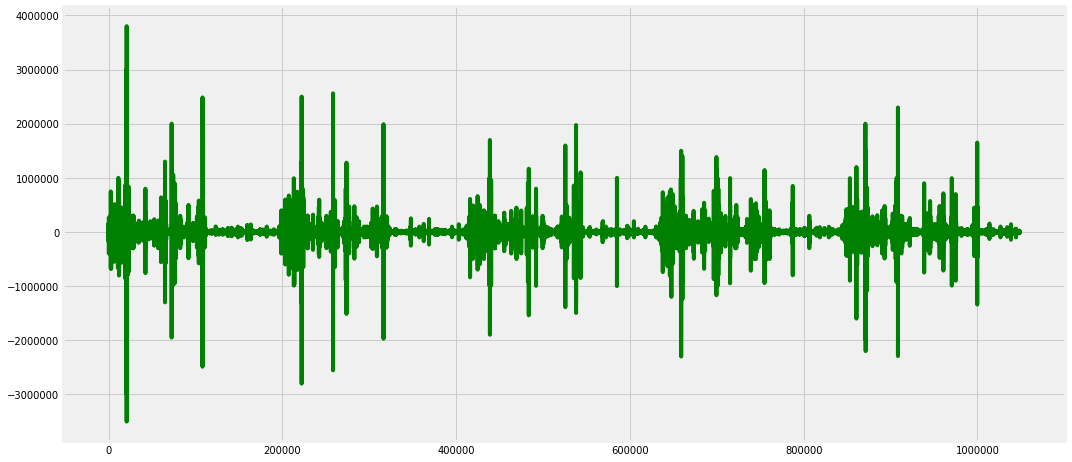

In [14]:
demand.diff().plot(figsize=(16,8), linestyle='solid', color='green')

Therefore, we can see some evidence that the first diference of the series induces some STATIONARITY to the series.

# Autocorrelation and Partial Autocorrelation Functions

## Autocorrelation of the demand

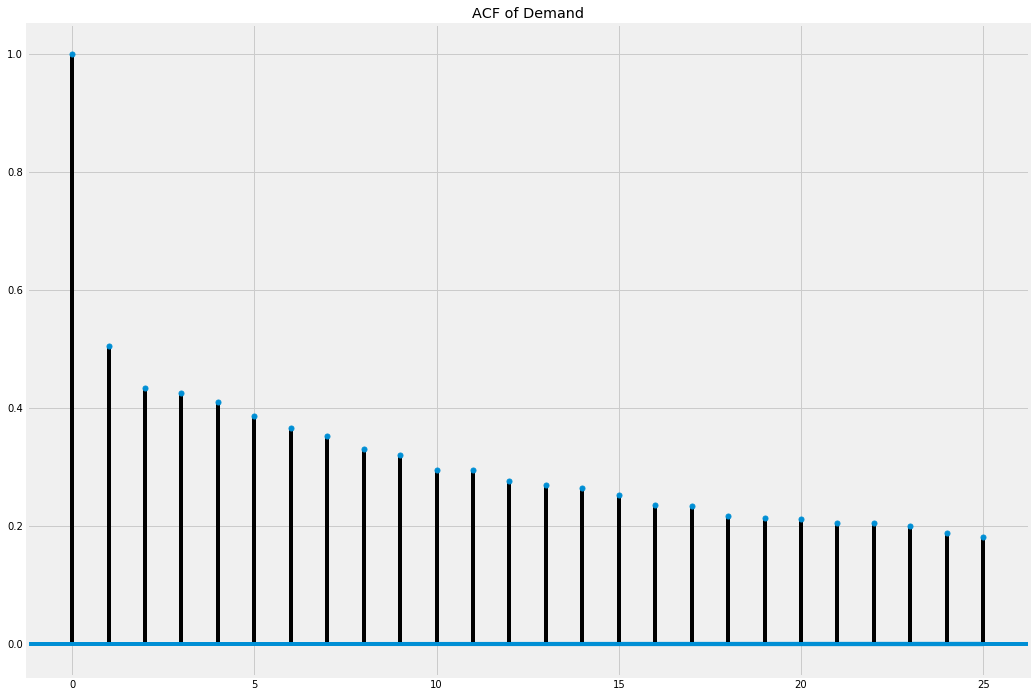

In [18]:
rcParams['figure.figsize'] = 16, 12
plot_acf(demand, lags=25,title="ACF of Demand")
plt.show()

## Partial Autocorrelation of the demand

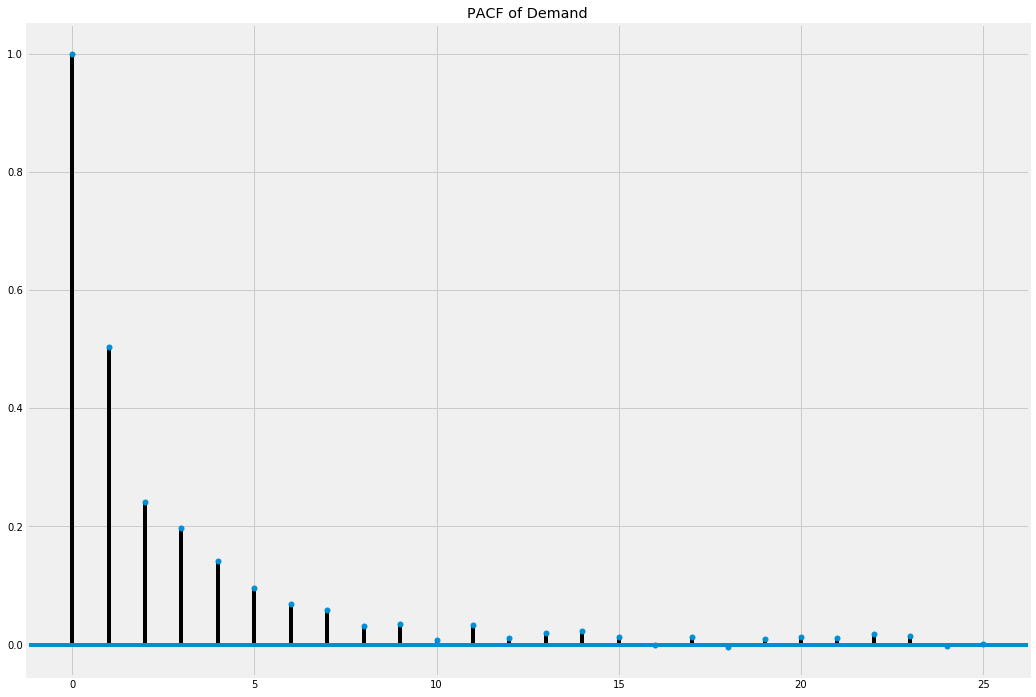

In [19]:
rcParams['figure.figsize'] = 16, 12
plot_pacf(demand,lags=25,title="PACF of Demand")
plt.show()

Therefore, autocorrelation function shows a declining pattern, being all legs until 25 statistically significant.
Now, notice that the Partial Autocorrelation function also shows a declining pattern; however, especially after 
lag 5 they are too small. 

# Simulation 4 AR models

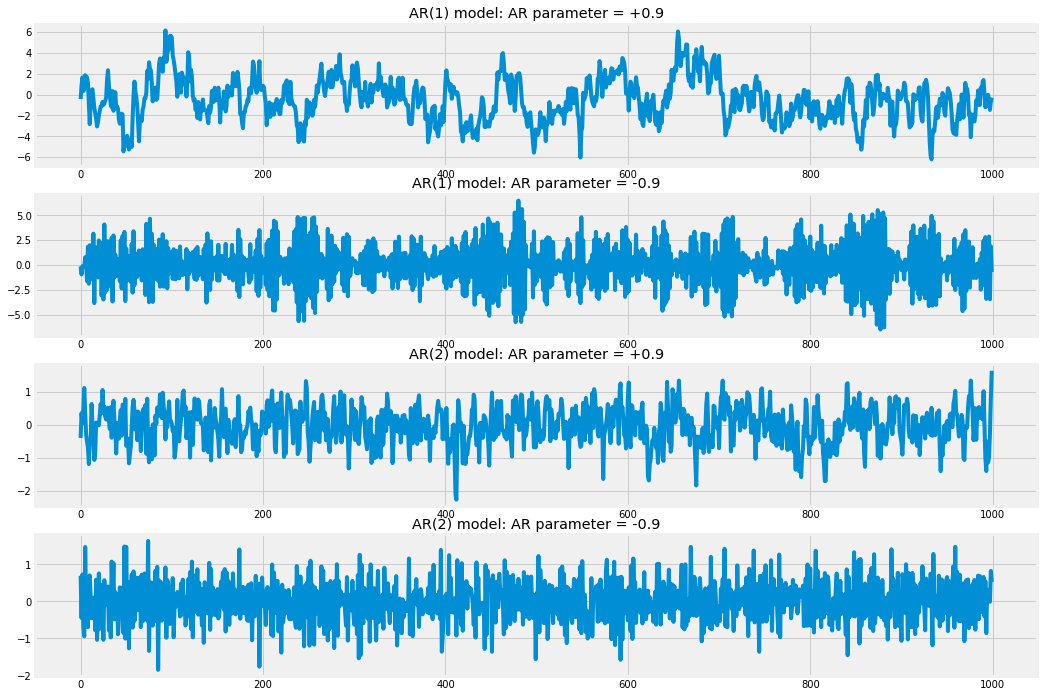

In [20]:
# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)
# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)
# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()

In [21]:
model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1434.117
Method:                       css-mle   S.D. of innovations              1.015
Date:                Wed, 28 Nov 2018   AIC                           2874.234
Time:                        13:10:31   BIC                           2888.957
Sample:                             0   HQIC                          2879.830
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4633      0.234     -1.983      0.048      -0.921      -0.005
ar.L1.y        0.8636      0.016     54.504      0.000       0.833       0.895
                                    Roots           

# Prediction

## Predicting my simulated AR(1) model 

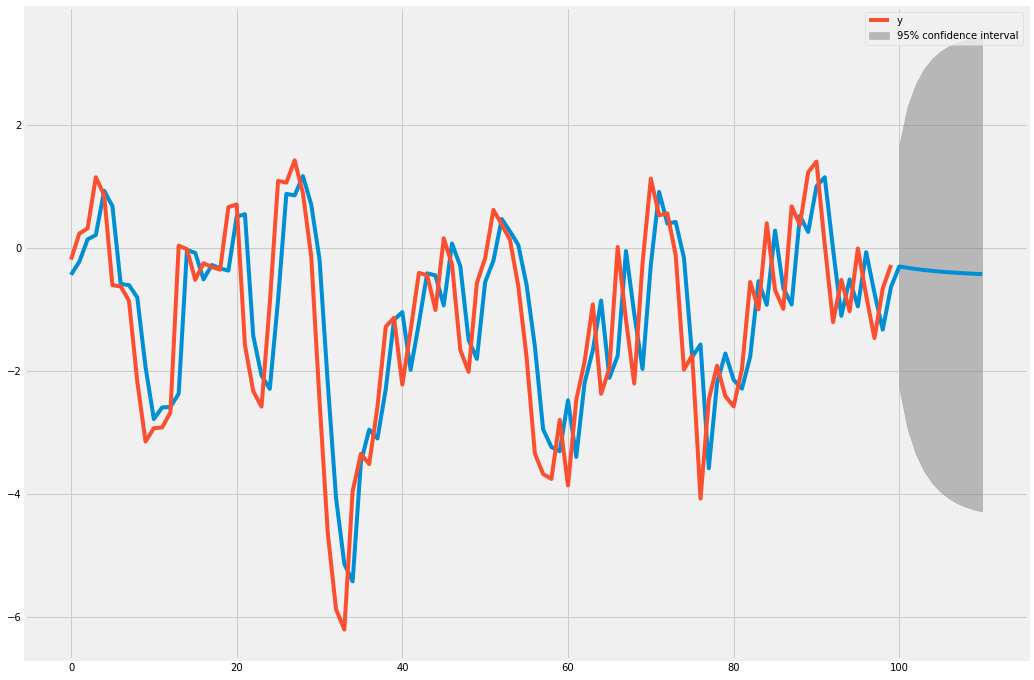

In [22]:
result.plot_predict(start=900, end=1010)
plt.show()

## Predicting Demand with my simulated AR(1), i.e., ARMA(1,0) for my observations from 10,000 to 11,000

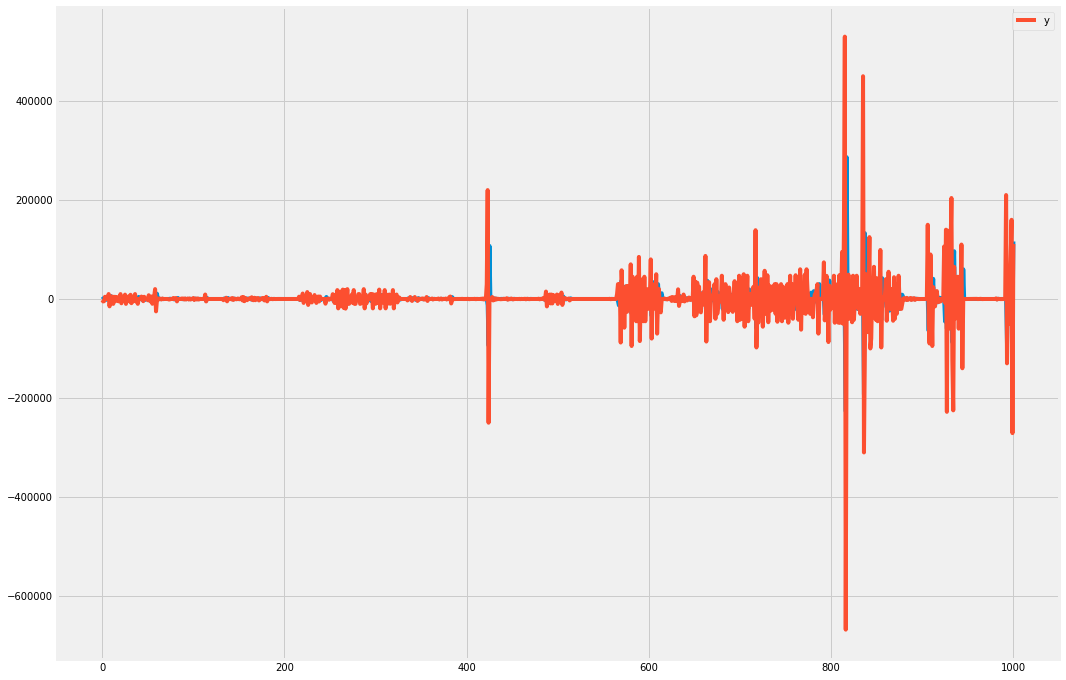

In [23]:
demand_arma = ARMA(demand.diff().iloc[1:].values, order=(1,0))
res = demand_arma.fit()
res.plot_predict(start=10000, end=11000)
plt.show()

## Predicting Demand with my simulated AR(1), i.e., ARMA(1,0) for my observations from 20,000 to 21,000

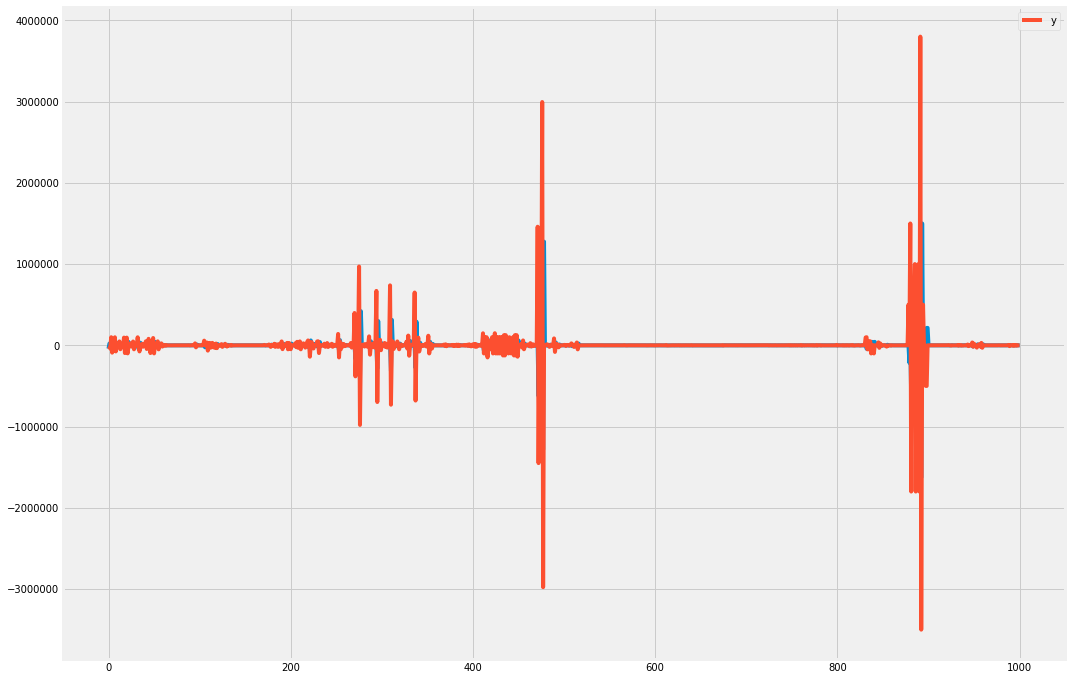

In [24]:
demand_arma = ARMA(demand.diff().iloc[1:].values, order=(1,0))
res = demand_arma.fit()
res.plot_predict(start=20000, end=21000)
plt.show()

In [25]:
rmse = math.sqrt(mean_squared_error(demand.diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 16315.445734394643.


Therefore, the AR(1) performs reasonably.

## Simulation of MA

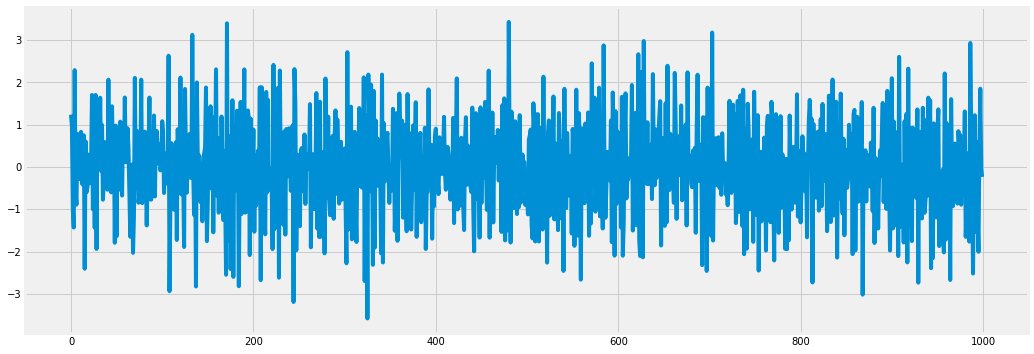

In [26]:
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
plt.plot(sim1)

# Forecasting the simulated MA model

In [27]:
model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1441.328
Method:                       css-mle   S.D. of innovations              1.022
Date:                Wed, 28 Nov 2018   AIC                           2888.656
Time:                        13:10:56   BIC                           2903.379
Sample:                             0   HQIC                          2894.252
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0191      0.016     -1.177      0.239      -0.051       0.013
ma.L1.y       -0.4975      0.026    -19.059      0.000      -0.549      -0.446
                                    Roots           

# Prediction using MA models
## Forecasting Demand

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:              1048574
Model:                     ARMA(0, 2)   Log Likelihood           -12039290.662
Method:                       css-mle   S.D. of innovations          23450.455
Date:                Wed, 28 Nov 2018   AIC                       24078589.323
Time:                        13:13:46   BIC                       24078636.775
Sample:                             0   HQIC                      24078602.357
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.892e-05      4.499  -1.98e-05      1.000      -8.817       8.817
ma.L1.y       -0.7058      0.001   -730.389      0.000      -0.708      -0.704
ma.L2.y       -0.0977      0.001    -95.320      0.0

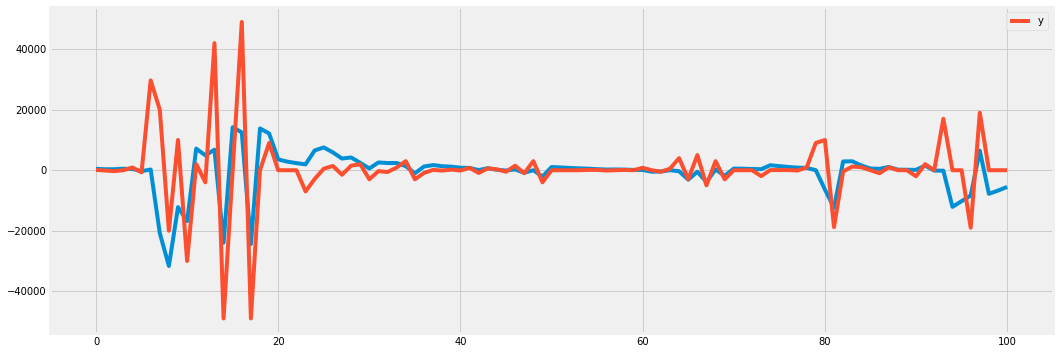

In [28]:
model = ARMA(demand.diff().iloc[1:].values, order=(0,2))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [29]:
rmse = math.sqrt(mean_squared_error(demand.diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 23606.349488961045.
